In [1]:
using GynC, Distributions, Sundials, Plots

cookie: oLNuHC4oPGhO39GZ
VERSION: 0.5.0


worker_arg: `--worker oLNuHC4oPGhO39GZ`


In [2]:
function fitzfn(tau)
  a = .7
  b = .8
  r = tau  
  I = .5

  function fitzhughnagumo(t,y,dy)
    v = y[1]
    w = y[2]
    dy[1] = v - v^3/3 - w + I
    dy[2] = (v + a - b*w) / r
  end
end

fitzfn (generic function with 1 method)

In [3]:
phi(tau) =  Sundials.cvode(fitzfn(tau), [1.,0.1], [0,40.])[2,1]

phi (generic function with 1 method)

In [4]:
xs = 15:1/3:55

15.0:0.3333333333333333:55.0


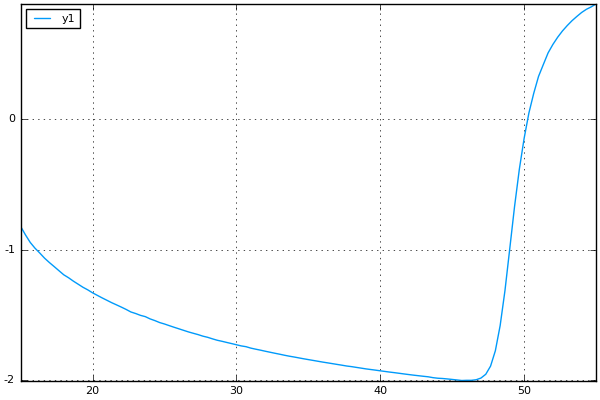

In [5]:
plot(xs,[phi(tau) for tau = xs])

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))



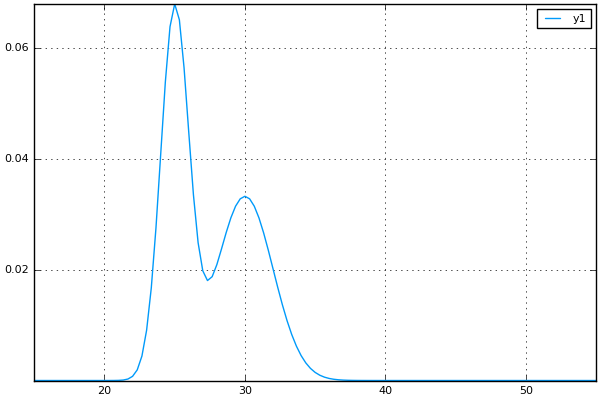

In [6]:
prior = MixtureModel([Normal(25,1), Normal(30,2)])

wprior = pdf(prior, xs)
wprior = wprior / sum(wprior);

plot(xs,wprior)

In [24]:
function syntethiclikelihoodmodel(xs, phi, prior, ndata, zmult, measerr)
  ys = phi.(xs)
  zs = repmat(ys, zmult) + rand(measerr, length(ys)*zmult)
  datas = phi.(rand(prior, ndata)) + rand(measerr, ndata)
  GynC.LikelihoodModel(xs, ys, zs, datas, measerr)
end

syntethiclikelihoodmodel (generic function with 1 method)

In [27]:
ndata = 1
zmult = 100
measerr = Normal(0, 0.1);

m = syntethiclikelihoodmodel(xs, phi, prior, ndata, zmult, measerr);

INFO: computing likelihood matrix (1x121)
INFO: computing likelihood matrix (12100x121)



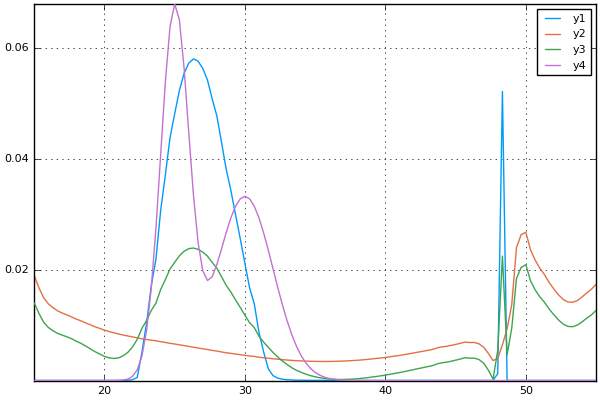

In [28]:
w0 = ones(length(xs)) / length(xs)

niter = 10

wl = GynC.mple(m, w0, niter, 0, 1)[end]
we = GynC.mple(m, w0, niter, 1, 1)[end]
w  = GynC.mple(m, w0, niter, .5, 1)[end]

plot(xs,[wl we w wprior])

In [29]:
function dslikelihoodmodel(m::GynC.LikelihoodModel, dmult, sigmak)
  sdatas = repmat(m.datas, dmult) + rand(Normal(0,sigmak), length(m.datas) * dmult);
  smeaserr = Normal(0, sqrt(m.measerr.σ^2 + sigmak^2))
  ms = GynC.LikelihoodModel(m.xs, m.ys, m.zs, sdatas, smeaserr, m.zsampledistr)
end

ms = dslikelihoodmodel(m, 30, 0.1);

In [30]:
wds = GynC.em(ms, w0, niter);
wds2 = GynC.mple(ms, w0, niter, 0, 1);

INFO: computing likelihood matrix (121x30)
INFO: computing likelihood matrix (30x121)



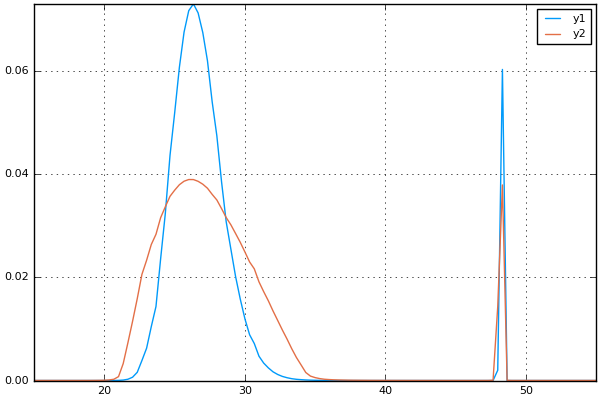

In [31]:
plot(xs,[wds[end], wds2[end]])